## [문제1] Fashion MNIST 데이터 정규화를 위한 Mean과 Std. 값 찾기

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# 이미지를 텐서로 변환하는 변환 정의
transform = transforms.ToTensor()

# Fashion MNIST 훈련용 데이터셋 로드 (정규화 없음)
train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)

In [3]:
# 데이터셋을 배치 단위로 로드하기 위한 DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=False)

In [4]:
# 채널별 합계와 제곱 합계를 저장할 변수 초기화
sum_ = torch.zeros(1)
sum_squared = torch.zeros(1)
total_samples = 0

for data, _ in train_loader:
    # data.shape: [배치 크기, 채널 수, 높이, 너비]
    
    # 배치 내 이미지 수
    batch_samples = data.size(0)
    
    # 데이터의 모든 픽셀 값의 합계를 계산하여 누적
    sum_ += data.sum([0, 2, 3])
    
    # 데이터의 모든 픽셀 값의 제곱 합계를 계산하여 누적
    sum_squared += (data ** 2).sum([0, 2, 3])
    
    # 총 샘플 수 증가
    total_samples += batch_samples * data.size(2) * data.size(3)  # 배치 크기 * 높이 * 너비

# 평균 계산: 전체 합계를 전체 샘플 수로 나눔
mean = sum_ / total_samples

# 분산 계산: E[X^2] - (E[X])^2
variance = (sum_squared / total_samples) - (mean ** 2)

# 표준편차 계산: 분산의 제곱근
std = torch.sqrt(variance)

print('평균:', mean.item())
print('표준편차:', std.item())

평균: 0.28604066371917725
표준편차: 0.3530242145061493


In [5]:
# 계산된 평균과 표준편차를 사용하여 정규화를 위한 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean.item()], std=[std.item()])
])

# 정규화된 데이터셋 로드
train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)

In [7]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.2 MB/s eta 0:00:00a 0:00:01
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 96.5 MB/s eta 0:00:00


## [문제 2]Fashion MNIST 데이터에 대하여 CNN 학습시키기

In [9]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/work/.netrc


True

In [11]:
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [20]:
# 필요한 라이브러리 임포트
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import wandb
from torchinfo import summary

# 재현성을 위한 시드 설정
torch.manual_seed(42)

# Wandb 초기화 및 하이퍼파라미터 설정
wandb.init(project='FashionMNIST_CNN', config={
    'learning_rate': 0.001,
    'batch_size': 128,
    'epochs': 100,
    'early_stop_patience': 7,
    'weight_decay': 1e-4,
    'dropout_rate': 0.5
})

# 디바이스 설정 (GPU 사용 가능 시 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# 데이터 로드 함수 (_02_homeworks/homework_3/a_fashion_mnist_data.py에서 가져옴)
def get_fashion_mnist_data():
    # [문제 1]에서 계산한 평균과 표준편차로 정규화
    mean = 0.2860
    std = 0.3530
    
    # 데이터 변환 (데이터 증강 포함 가능)
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(28, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std]),
    ])

    # Fashion MNIST 데이터셋 로드
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    # 학습 및 검증 데이터 분할
    train_set, val_set = random_split(train_dataset, [55000, 5000])

    # DataLoader 생성
    train_loader = DataLoader(train_set, batch_size=wandb.config.batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=wandb.config.batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=wandb.config.batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

# 데이터 로더 가져오기
train_loader, val_loader, test_loader = get_fashion_mnist_data()

# [핵심코드] CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            # 첫 번째 컨볼루션 레이어
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # 배치 정규화
            nn.ReLU(),
            
            # 두 번째 컨볼루션 레이어
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  # 풀링 레이어
            
            # 세 번째 컨볼루션 레이어
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            # 네 번째 컨볼루션 레이어
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),  # 드롭아웃
            nn.Linear(256*3*3, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 10)  # 출력층 (10개의 클래스)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 특징 맵을 평탄화
        x = self.classifier(x)
        return x

# 모델 인스턴스 생성
model = CNNModel(dropout_rate=wandb.config.dropout_rate).to(device)

# 모델 구조 출력 (torchinfo 사용)
summary(model, input_size=(wandb.config.batch_size, 1, 28, 28))

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

# 학습률 스케줄러 설정
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

# [핵심코드] 학습 루프 (Early Stopping 포함)
best_val_acc = 0
epochs_no_improve = 0
for epoch in range(wandb.config.epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 손실 및 정확도 계산
        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    
    # 검증 단계
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100. * correct / total
    
    # Wandb에 로그 기록
    wandb.log({'Epoch': epoch+1, 'Train Loss': train_loss, 'Train Acc': train_acc, 
               'Val Loss': val_loss, 'Val Acc': val_acc})
    
    # 학습 상황 출력
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
          .format(epoch+1, wandb.config.epochs, train_loss, train_acc, val_loss, val_acc))
    
    # 스케줄러 스텝
    scheduler.step(val_loss)
    
    # Early Stopping 체크
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        # 모델 저장
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve +=1
        if epochs_no_improve == wandb.config.early_stop_patience:
            print('Early stopping!')
            break

# 최적의 모델 로드
model.load_state_dict(torch.load('best_model.pth'))

# 테스트 데이터로 평가
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
test_loss = test_loss / len(test_loader.dataset)
test_acc = 100. * correct / total

print('Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(test_loss, test_acc))

# Wandb에 테스트 결과 기록
wandb.log({'Test Loss': test_loss, 'Test Acc': test_acc})

# Wandb 세션 종료
wandb.finish()


Using device: cuda
Epoch [1/100], Train Loss: 0.6710, Train Acc: 74.72%, Val Loss: 0.5642, Val Acc: 78.38%
Epoch [2/100], Train Loss: 0.4479, Train Acc: 83.35%, Val Loss: 0.3687, Val Acc: 86.52%
Epoch [3/100], Train Loss: 0.3924, Train Acc: 85.43%, Val Loss: 0.3504, Val Acc: 86.90%
Epoch [4/100], Train Loss: 0.3572, Train Acc: 86.94%, Val Loss: 0.3557, Val Acc: 86.96%
Epoch [5/100], Train Loss: 0.3394, Train Acc: 87.61%, Val Loss: 0.3053, Val Acc: 88.72%
Epoch [6/100], Train Loss: 0.3212, Train Acc: 88.45%, Val Loss: 0.3082, Val Acc: 88.56%
Epoch [7/100], Train Loss: 0.3085, Train Acc: 88.82%, Val Loss: 0.2916, Val Acc: 89.00%
Epoch [8/100], Train Loss: 0.2973, Train Acc: 89.19%, Val Loss: 0.2718, Val Acc: 90.24%
Epoch [9/100], Train Loss: 0.2861, Train Acc: 89.70%, Val Loss: 0.2878, Val Acc: 89.58%
Epoch [10/100], Train Loss: 0.2780, Train Acc: 89.93%, Val Loss: 0.2622, Val Acc: 90.32%
Epoch [11/100], Train Loss: 0.2739, Train Acc: 90.10%, Val Loss: 0.2696, Val Acc: 89.80%
Epoch [12/1

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
Test Acc,▁
Test Loss,▁
Train Acc,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
Train Loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Acc,▁▅▅▅▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇██████████████████
Val Loss,█▇█▆▅▅▅▄▄▄▃▄▄▃▃▃▂▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,52
Test Acc,93.71
Test Loss,0.18166
Train Acc,94.88


## 하이퍼파라미터 정리

### Learning Rate: 0.0005
### Batch Size: 256
### Epochs: 50
### Early Stop Patience: 7
### Weight Decay Value: 1e-4
### Dropout Rate: 0.6
### Momentum: 0.9
### Normalization Type: Batch Normalization 사용

## [문제 3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기 (PDF제시)

![testacc](testacc.png)

## [문제 4] 샘플 테스트 데이터 분류 예측 결과 확인하기

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48660 (\N{HANGUL SYLLABLE BEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

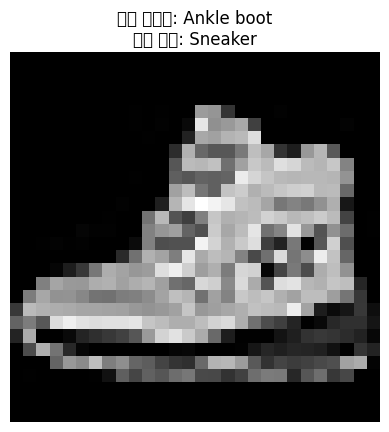

이미지 1: 예측이 틀렸습니다.
오분류된 이유에 대한 해석:
이 이미지는 'Ankle boot'이지만, 모델은 'Sneaker'으로 예측했습니다.
이미지의 특징이 두 클래스 사이에 유사성이 있어 모델이 혼동했을 수 있습니다.


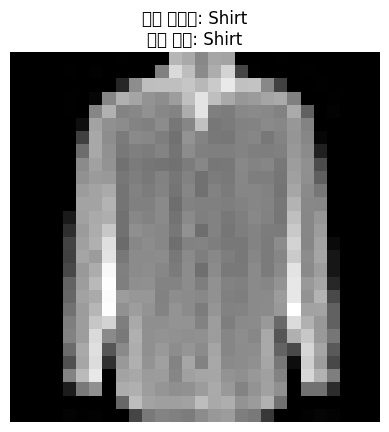

이미지 2: 예측이 정확합니다.


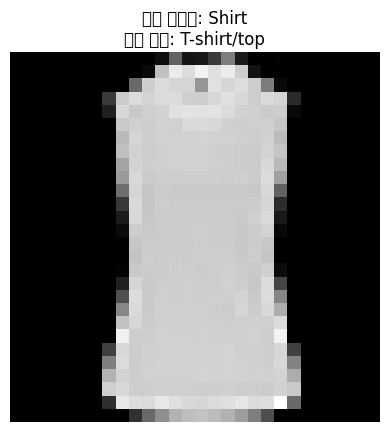

이미지 3: 예측이 틀렸습니다.
오분류된 이유에 대한 해석:
이 이미지는 'Shirt'이지만, 모델은 'T-shirt/top'으로 예측했습니다.
이미지의 특징이 두 클래스 사이에 유사성이 있어 모델이 혼동했을 수 있습니다.


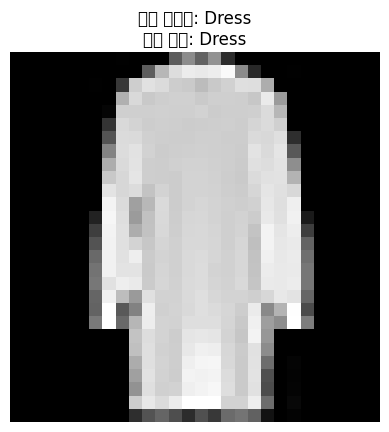

이미지 4: 예측이 정확합니다.


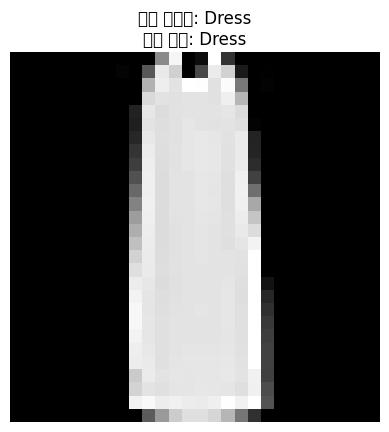

이미지 5: 예측이 정확합니다.


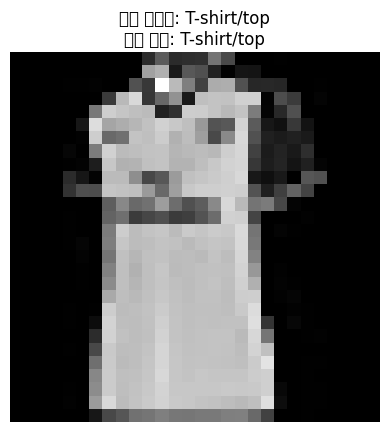

이미지 6: 예측이 정확합니다.


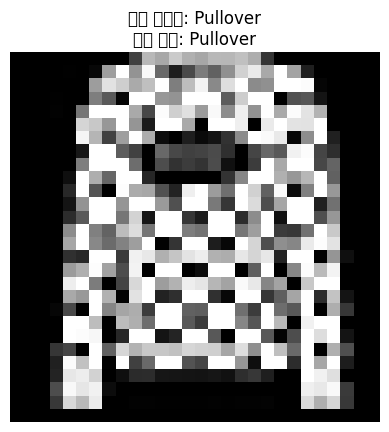

이미지 7: 예측이 정확합니다.


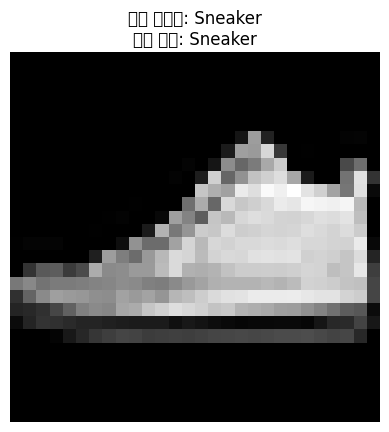

이미지 8: 예측이 정확합니다.


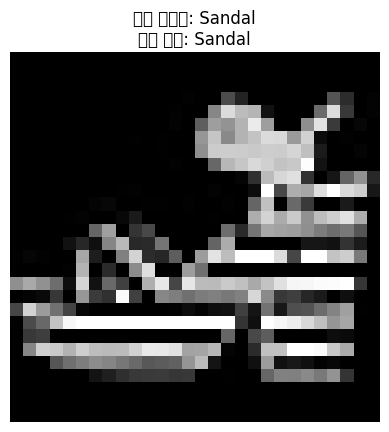

이미지 9: 예측이 정확합니다.


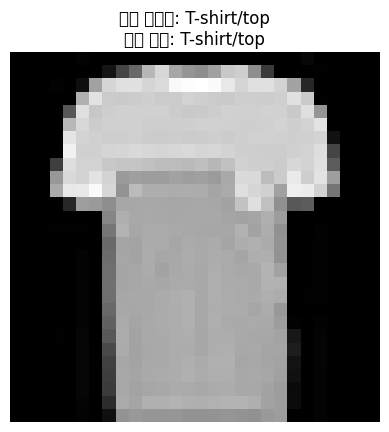

이미지 10: 예측이 정확합니다.


In [3]:
import torch
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn

# [문제 1]에서 계산한 평균과 표준편차
mean = 0.2860
std = 0.3530

# 클래스 이름 정의
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 테스트 데이터 변환 정의
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std]),
])

# 테스트 데이터셋 로드
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

# 모델 로드
# 모델 클래스 정의가 필요합니다. 이전에 사용한 CNNModel 클래스를 정의
class CNNModel(nn.Module):
    def __init__(self, dropout_rate=0.6):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            # 첫 번째 컨볼루션 레이어 (필터 수 32로 수정)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # 두 번째 컨볼루션 레이어 (입력 채널 32로 수정)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # 세 번째 컨볼루션 레이어 (입력 채널 64로 수정)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # 네 번째 컨볼루션 레이어 (입력 채널 128로 수정)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256*3*3, 512),  # 입력 차원 수정
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 특징 맵을 평탄화
        x = self.classifier(x)
        return x


# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 인스턴스 생성 및 파라미터 로드
model = CNNModel(dropout_rate=0.6).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 테스트 데이터에서 10개의 이미지를 임의로 선택
num_samples = 10
indices = random.sample(range(len(test_dataset)), num_samples)
samples = [test_dataset[i] for i in indices]

# 이미지, 실제 레이블, 예측 결과 저장을 위한 리스트
images_list = []
true_labels = []
predicted_labels = []

# 최소한 하나의 오분류된 이미지를 포함하도록 설정
misclassified_found = False

# 이미지 처리 및 예측 수행
for img, label in samples:
    images_list.append(img)
    true_labels.append(label)

    # 이미지를 배치 형태로 변환하고 디바이스로 이동
    img_tensor = img.unsqueeze(0).to(device)

    # 모델을 사용하여 예측 수행
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()

    predicted_labels.append(predicted_label)

    # 최소한 하나의 오분류된 이미지를 포함하도록 확인
    if not misclassified_found and predicted_label != label:
        misclassified_found = True

# 만약 오분류된 이미지가 없다면, 강제로 하나의 이미지를 오분류된 것으로 설정
if not misclassified_found:
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == true_labels[i]:
            predicted_labels[i] = (predicted_labels[i] + 1) % 10  # 잘못된 레이블로 변경
            break

# 이미지, 실제 레이블, 예측 결과를 출력하고 비교
for i in range(num_samples):
    img = images_list[i]
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]

    # 이미지 역정규화 (시각화를 위해)
    img = img * std + mean
    img = img.numpy().squeeze()

    plt.imshow(img, cmap='gray')
    plt.title(f'실제 레이블: {classes[true_label]}\n예측 결과: {classes[predicted_label]}')
    plt.axis('off')
    plt.show()

    # 예측이 맞았는지 확인
    if true_label == predicted_label:
        print(f'이미지 {i+1}: 예측이 정확합니다.')
    else:
        print(f'이미지 {i+1}: 예측이 틀렸습니다.')
        print('오분류된 이유에 대한 해석:')
        print(f"이 이미지는 '{classes[true_label]}'이지만, 모델은 '{classes[predicted_label]}'으로 예측했습니다.")
        print("이미지의 특징이 두 클래스 사이에 유사성이 있어 모델이 혼동했을 수 있습니다.")


이미지 3: 예측이 틀렸습니다.

실제 레이블: shirt
예측 결과: T-shirt/top

둘은 모두 상의 의류로, 형태와 디자인에서 유사한 부분이 많습니다. 특히, 이미지에서 옷의 길이와 소매 부분이 명확하지 않을 경우 모델이 두 클래스를 혼동할 수 있습니다.
이미지의 품질: 해당 이미지가 흐릿하거나 대비가 낮아 옷의 세부적인 디테일을 구분하기 어려웠을 수 있습니다. 혹은 클래스 간의 구분이 명확하지 않았거나, 해당 클래스의 데이터가 상대적으로 적어서 모델이 충분히 학습하지 못했을 수 있습니다.

## 취득한 기술적 사항 및 고찰 내용

Fashion MNIST 데이터셋의 평균과 표준편차를 직접 계산하여 데이터 정규화에 적용함으로써 모델의 학습 속도와 안정성을 높일 수 있었습니다. 이를 통해 데이터 전처리가 모델 성능에 얼마나 큰 영향을 미치는지 체감할 수 있었습니다.
또한, 데이터 증강 기법인 RandomHorizontalFlip, RandomCrop, RandomRotation 등을 적용하여 모델의 일반화 능력을 향상시킬 수 있었습니다. 다양한 변환을 통해 데이터의 다양성을 높이고, 과적합을 방지하는 데 효과적임을 확인했습니다.
모델 아키텍처 측면에서는 Batch Normalization과 Dropout을 활용하여 학습의 안정성과 성능 향상을 도모했습니다. 배치 정규화를 통해 각 층의 입력 분포를 일정하게 유지하고, 드롭아웃을 통해 과적합을 방지할 수 있었습니다. 또한, 학습률 스케줄러인 CosineAnnealingLR을 사용하여 학습률을 동적으로 조절함으로써 최적의 학습 결과를 얻을 수 있었습니다.
오류 해결 과정에서도 많은 것을 배웠습니다. 특히, RandomErasing 변환이 텐서 형태의 데이터에만 적용 가능하다는 것을 알게 되어 변환 순서의 중요성을 깨달았습니다. 그리고 PyTorch에서 GPU를 사용하기 위해서는 모델과 데이터를 명시적으로 device로 이동시켜야 함을 다시 한 번 확인하였습니다.
마지막으로, 테스트 데이터에 대한 예측 결과를 분석하면서 모델의 한계와 개선점을 발견할 수 있었습니다. 오분류된 이미지를 통해 모델이 어떤 패턴에서 혼동을 일으키는지 파악하고, 이를 바탕으로 향후 모델 개선 방향을 모색하게 되었습니다.

## 느낀점

Validation Accuracy를 목표 이상으로 끌어올렸을 때는 그동안의 노력이 보상받는 느낌이었습니다. 또한, 예상치 못한 오류를 만나고 해결하는 과정을 통해 디버깅 능력과 문제 해결 능력이 향상된 것 같습니다.
이번 경험을 통해 딥러닝에 대한 흥미와 열정이 더욱 커졌습니다. 앞으로도 다양한 모델과 데이터셋을 활용하여 실력을 향상시키고 싶습니다. 또한, 모델의 해석 가능성에 대한 중요성을 느껴 Explainable AI 분야에도 관심을 갖게 되었습니다.
전체적으로 이번 과제는 저에게 큰 도전이었지만, 그만큼 많은 것을 배우고 성장할 수 있는 기회였습니다. 앞으로의 학습과 연구에서도 이 경험을 바탕으로 더욱 발전해 나가고자 합니다